<a href="https://colab.research.google.com/github/bartala/Bankruptcy/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.0.0

In [1]:
%load_ext rpy2.ipython

/usr/local/lib/python3.9/dist-packages/rpy2/robjects/pandas2ri.py:15: FutureWarning: pandas.core.index is deprecated and will be removed in a future version. The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%R
lib_loc <- "/content/drive/MyDrive/Colab Notebooks/r-lib"

In [ ]:
%%R
install.packages("data.table", lib =lib_loc)
install.packages("ggpubr",lib =lib_loc)
install.packages("DescTools", lib =lib_loc)
install.packages("NbClust", lib =lib_loc)
install.packages("factoextra", lib =lib_loc)
install.packages("gsubfn", lib =lib_loc)
install.packages("proto", lib =lib_loc)
install.packages("ggplot2", lib =lib_loc)
install.packages("RSQLite", lib =lib_loc)
install.packages("sqldf", lib=lib_loc)
install.packages("chron",lib= lib_loc)
install.packages("minpack.lm",repos = "http://cran.us.r-project.org",lib=lib_loc)
install.packages("AICcmodavg",repos = "http://cran.us.r-project.org", lib=lib_loc)
install.packages("gridExtra",repos = "http://cran.us.r-project.org", lib=lib_loc)+
install.packages("rsq",repos = "http://cran.us.r-project.org", lib=lib_loc)
install.packages("caret",repos = "http://cran.us.r-project.org", lib=lib_loc) 

In [ ]:
%%R
library(RSQLite, lib.loc = lib_loc)
library(proto, lib.loc = lib_loc) 
library(gsubfn, lib.loc = lib_loc) 
library(readr, lib.loc = lib_loc)
library(ggplot2, lib.loc = lib_loc)
library(ggpubr, lib.loc = lib_loc)
library(pROC, lib.loc = lib_loc)
library(DescTools, lib.loc = lib_loc)
library(NbClust, lib.loc = lib_loc)
library(factoextra, lib.loc = lib_loc)
library(sqldf, lib.loc = lib_loc)
library(cowplot,lib.loc = lib_loc)
library(AICcmodavg,lib.loc = lib_loc)
library(minpack.lm,lib.loc = lib_loc)
library(gridExtra,lib.loc = lib_loc)
library(rsq,lib.loc = lib_loc)
library(caret,lib.loc = lib_loc)
library(broom)

In [5]:
%%R

# before covid data
PTH1 = "/content/drive/MyDrive/Colab Notebooks/BIU_HEB/data/"

### Load datasets of tweets posted before and after the announcment

In [7]:
%%R
data <- read_csv(paste0(PTH1,"2012_2022_bankruptcy.csv.zip"), show_col_types = FALSE)

metadata <- read_csv(paste0(PTH1,"Metadata_All_chapter11_new.csv"), show_col_types = FALSE)

In [8]:
%%R 

companies <- unique(data[data$dataset %in% c("before_covid", "covid"),]$company)
                    
companies_2 <- unique(data[data$dataset == 'all_2020_new',]$company)
companies_2 <- companies_2[companies_2 %in% metadata$`Twitter Username`]

companies <- union(companies,companies_2)

rm(companies_2)

In [9]:
%%R
data <- data[data$company %in% companies,]

### Descriptive statistics and data cleaning

In [10]:
%%R

# nuber of unique users in the posts
paste0("unique users: ", length(unique(data$author_id)) )

[1] "unique users: 132748"


In [11]:
%%R
# total number of tweets
print(
    paste0("total number of tweets (before and after the announcement): ",
           nrow(data)
          )
      )


# number of companis
print(paste0("number of companies: ",length(unique(data$company))) )


# number of tweets per company
table(data$company)

[1] "total number of tweets (before and after the announcement): 248936"
[1] "number of companies: 83"

    A123Systems         Abengoa     aeropostale        archcoal  ArmstrongFloor 
            110             235            7599            1108              42 
   AvadelPharma           Avaya    beautybrands            belk  BioRestorative 
             25            6920             109            1035               4 
 BrooksBrothers      Carestream century21stores  CharlotteRusse CharmingCharlie 
           2292              88             712             555              48 
   ChuckECheese       cineworld         claires  ClovisOncology  cobaltpowergrp 
           6216           24309            6417              17              23 
   CumulusMedia   DeanAndDeLuca    DendreonNews          DIESEL       ECOtality 
          34762              29              54            1378              33 
    EFCoalition  ElizabethArden   EMAS_offshore  EnergyGulfport      Ferrellgas 
     

In [12]:
# split data into before and after the announcement
%%R 


before <- data[grepl( 'before', data$data, fixed = TRUE),]

after <- data[grepl( 'after', data$data, fixed = TRUE),]


x_after <- nrow(after)
x_before <- nrow(before)

# delete messages originated by the companies

after <- after[!after$author_id %in% metadata$UserID,]

before <- before[!before$author_id %in% metadata$UserID,]


print( paste0("deleted tweets by companies after: ", x_after - nrow(after) ) )
print( paste0("deleted tweets by companies before: ", x_before - nrow(before) ) )

[1] "deleted tweets by companies after: 238"
[1] "deleted tweets by companies before: 218"


### Temporal analysis: number of mentions per day and company

In [13]:
%%R

before$created_at<-as.character(before$created_at)
after$created_at<-as.character(after$created_at)

# keep only day date (no time)
before$date <- substr(before$created_at,0,10)
after$date <- substr(after$created_at,0,10)

temp_before <- sqldf("select company, date, count(1) as freq from before group by company, date")

temp_before$when<-'before'

temp_after <-  sqldf("select company, date, count(1) as freq from after group by company, date")

temp_after$when<-'after'

tmp <- rbind(temp_before, temp_after)

tmp <- merge(tmp,metadata, by.x='company', by.y='Twitter Username')

tmp$number <- as.Date(tmp$date) - as.Date(tmp$`Date of Bankruptcy`,format = "%B %d, %Y") # day diff from bankruptcy (in unix timestamp)

tmp <- tmp[(tmp$number) < 31 & (tmp$number) > (-31),] # remove tweets more than 30 pre/post announcement

tmp <- tmp[ tmp$company %in% intersect(tmp[tmp$when == 'before',]$company, tmp[tmp$when == 'after',]$company),] # keep only companies that appear in both the `before` and `after` datasets

# save temporary file for future analyses
write.csv(tmp,file='data0.csv', row.names = FALSE)

In [14]:
# analyzed companies after data cleaning
%%R 
unique(tmp$company)

 [1] "A123Systems"     "Abengoa"         "aeropostale"     "archcoal"       
 [5] "ArmstrongFloor"  "AvadelPharma"    "Avaya"           "beautybrands"   
 [9] "belk"            "BioRestorative"  "BrooksBrothers"  "Carestream"     
[13] "century21stores" "CharlotteRusse"  "ChuckECheese"    "cineworld"      
[17] "claires"         "ClovisOncology"  "cobaltpowergrp"  "CumulusMedia"   
[21] "DeanAndDeLuca"   "DendreonNews"    "DIESEL"          "ECOtality"      
[25] "EFCoalition"     "ElizabethArden"  "EMAS_offshore"   "EnergyGulfport" 
[29] "Ferrellgas"      "flyPAL"          "Forever21"       "francescas"     
[33] "ftdflowers"      "GNCLiveWell"     "GoldsGym"        "Golfsmith"      
[37] "guitarcenter"    "Hertz"           "hhgregg"         "HMHCo"          
[41] "HMNYHQ1"         "iHeartMedia"     "IndianaTollRoad" "IndonesiaGaruda"
[45] "investvoyager"   "jcpenney"        "jcrew"           "KikoMilanoUSA"  
[49] "Kodak"           "linnenergy"      "lootcrate"       "lordandtaylor"  

In [15]:
# calc avg. mention time before and after the bankruptcy announcment

%%R

df1 <- sqldf("select company, avg(freq) as avg_freq from tmp where `when`='after' group by company") # after
df1$When = "After"

df2 <- sqldf("select company, avg(freq) as avg_freq from tmp where `when`='before' group by company") # before
df2$When = "Before"

df_1 <- rbind(df1,df2)

#### Companies with more tweets after the announcement (on average) than before the announcment 

(i.e., they were not forgotten by the public)


In [16]:
%%R 
df_2 <- data.frame(
              Company = df1$company, 
              After = df1$avg_freq, 
              Before = df2$avg_freq
              )

 [1] "A123Systems"     "Abengoa"         "AvadelPharma"    "Avaya"          
 [5] "BioRestorative"  "BrooksBrothers"  "CharlotteRusse"  "ChuckECheese"   
 [9] "ClovisOncology"  "DendreonNews"    "ECOtality"       "EMAS_offshore"  
[13] "ElizabethArden"  "Ferrellgas"      "Forever21"       "GNCLiveWell"    
[17] "GoldsGym"        "Golfsmith"       "HMHCo"           "HMNYHQ1"        
[21] "Hertz"           "IndonesiaGaruda" "Kodak"           "LuckinCoffee"   
[25] "LuckyBrand"      "MadCatz"         "MarieCallenders" "MattressFirm"   
[29] "Modells"         "MusclePharm"     "NineWest"        "RealGoods"      
[33] "RepublicAirways" "Sears"           "TrueReligion"    "archcoal"       
[37] "beautybrands"    "century21stores" "claires"         "francescas"     
[41] "jcpenney"        "jcrew"           "linnenergy"      "lordandtaylor"  
[45] "neimanmarcus"    "peabodyenergy"   "pier1"           "revlon"         
[49] "steinmart"       "terravia"       


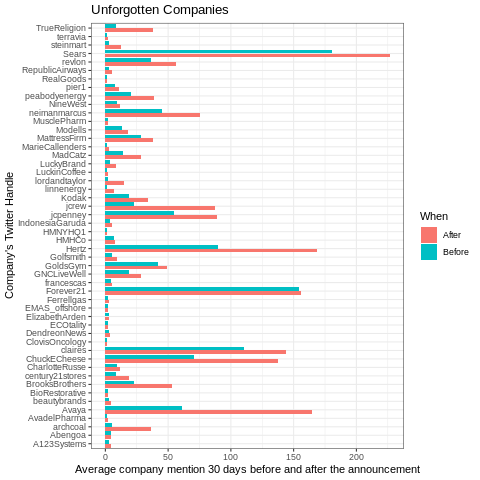

In [17]:
# unforgotten companies
%%R

unforgotten_comp <- df_1[df_1$company %in% (df_2[df_2$After >= df_2$Before,'Company']),]
print(unique(unforgotten_comp$company))

ggplot(unforgotten_comp, aes(company, avg_freq, fill=When)) +
  geom_bar(stat = "identity", position = 'dodge') +
  theme_bw() +
  ggtitle("Unforgotten Companies") +
  ylab("Average company mention 30 days before and after the announcement") + xlab("Company's Twitter Handle")+
  coord_flip()

 [1] "ArmstrongFloor"  "Carestream"      "CumulusMedia"    "DIESEL"         
 [5] "DeanAndDeLuca"   "EFCoalition"     "EnergyGulfport"  "IndianaTollRoad"
 [9] "KikoMilanoUSA"   "Momentive"       "MtGox"           "Perfumania"     
[13] "PyxusIntl"       "Rockport"        "SunEdison"       "Suntech_Connect"
[17] "TailorBrands"    "aeropostale"     "belk"            "cineworld"      
[21] "cobaltpowergrp"  "flyPAL"          "ftdflowers"      "guitarcenter"   
[25] "hhgregg"         "iHeartMedia"     "investvoyager"   "lootcrate"      
[29] "rue21"           "sugarfina"       "verso_group"    


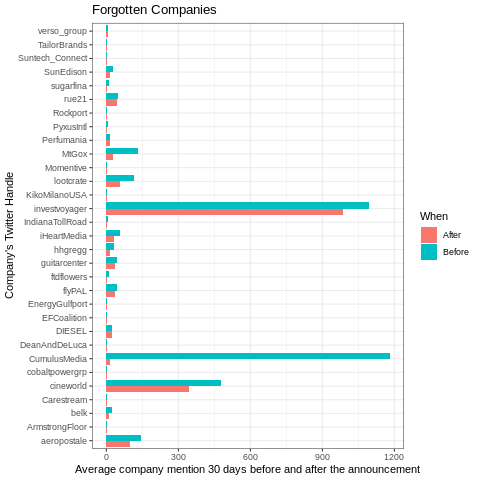

In [18]:
# forgotten companies

%%R

forgotten_comp <- df_1[df_1$company %in% (df_2[df_2$After < df_2$Before,'Company']),]
print(unique(forgotten_comp$company))


ggplot(forgotten_comp, aes(company, avg_freq, fill=When)) +
  geom_bar(stat = "identity", position = 'dodge') +
  theme_bw() +
  ggtitle("Forgotten Companies") +
  ylab("Average company mention 30 days before and after the announcement") + xlab("Company's Twitter Handle")+
  coord_flip()

### Model comparison: **Unforgotten**

In [19]:
# Unforgotten companies

%%R

Unforgotten <- tmp[ (tmp$company) %in% (df_2[df_2$After >= df_2$Before,'Company']) & tmp$number >=0, ] # number:= number of days since bankruptcy announcement

Unforgotten <- sqldf("select avg(freq) as avg, number from Unforgotten group by number",method = "name__class")

Unforgotten_companies <- df_2[df_2$After >= df_2$Before,'Company']

# number of companies
print( Unforgotten_companies )

 [1] "A123Systems"     "Abengoa"         "AvadelPharma"    "Avaya"          
 [5] "BioRestorative"  "BrooksBrothers"  "CharlotteRusse"  "ChuckECheese"   
 [9] "ClovisOncology"  "DendreonNews"    "ECOtality"       "EMAS_offshore"  
[13] "ElizabethArden"  "Ferrellgas"      "Forever21"       "GNCLiveWell"    
[17] "GoldsGym"        "Golfsmith"       "HMHCo"           "HMNYHQ1"        
[21] "Hertz"           "IndonesiaGaruda" "Kodak"           "LuckinCoffee"   
[25] "LuckyBrand"      "MadCatz"         "MarieCallenders" "MattressFirm"   
[29] "Modells"         "MusclePharm"     "NineWest"        "RealGoods"      
[33] "RepublicAirways" "Sears"           "TrueReligion"    "archcoal"       
[37] "beautybrands"    "century21stores" "claires"         "francescas"     
[41] "jcpenney"        "jcrew"           "linnenergy"      "lordandtaylor"  
[45] "neimanmarcus"    "peabodyenergy"   "pier1"           "revlon"         
[49] "steinmart"       "terravia"       


In [20]:
# models
%%R

Unforgotten$x = Unforgotten$number
Unforgotten$y = Unforgotten$avg

# Exponential
expmodel_uf <- lm(y~exp(x), data = Unforgotten)
print(summary(expmodel_uf))

# Log
logmodel_uf <- lm(y~log(x+0.01), data = Unforgotten)
print(summary(logmodel_uf))

# Hyperbolic
hyper_fit_uf <- nlsLM(y ~ a/(1 + b * x), data = Unforgotten, start = list(a = 1, b = 1))
print(summary(hyper_fit_uf))

# Biexponential
biexp_fit_uf <- nlsLM(y ~ a1*exp(-b1*x) + a2*exp(-b2*x), data = Unforgotten, start = c(a1 = 5, b1 = 2, a2 = 3, b2 = 0.5))
print(summary(biexp_fit_uf))

# Fit a power law curve using nls
power_fit_uf <- nls(y ~ a * (x+0.0001)^(-b), data = Unforgotten, start = list(a = 1, b = 1))
summary(power_fit_uf)


Call:
lm(formula = y ~ exp(x), data = Unforgotten)

Residuals:
    Min      1Q  Median      3Q     Max 
-30.649 -22.445 -13.304   2.087 172.756 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.314e+01  8.783e+00   6.050 1.39e-06 ***
exp(x)      -1.259e-12  4.255e-12  -0.296     0.77    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 47.16 on 29 degrees of freedom
Multiple R-squared:  0.003008,	Adjusted R-squared:  -0.03137 
F-statistic: 0.08749 on 1 and 29 DF,  p-value: 0.7695


Call:
lm(formula = y ~ log(x + 0.01), data = Unforgotten)

Residuals:
    Min      1Q  Median      3Q     Max 
-30.450 -17.058  -1.963   8.728  97.778 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    110.212      8.382  13.148 9.53e-14 ***
log(x + 0.01)  -25.546      3.090  -8.267 4.10e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 25.78 o

In [21]:
%%R 

gof <- function(model){
    
    return( 
              glance(model) %>% 
                  dplyr::select(adj.r.squared, sigma, AIC, BIC, p.value)
    )

}


print(paste0("AIC exp: ", gof(expmodel_uf)$AIC))
print(paste0("AIC log: ",gof(logmodel_uf)$AIC))
print(paste0("AIC hypr: ",AIC(hyper_fit_uf)))
print(paste0("AIC biex: ",AIC(biexp_fit_uf)))
print(paste0("AIC power: ",AIC(power_fit_uf)))

[1] "AIC exp: 330.831344149559"
[1] "AIC log: 293.385717126216"
[1] "AIC hypr: 344.096713867418"
[1] "AIC biex: 267.41810172333"
[1] "AIC power: 303.281272923105"


In [22]:
# clac R^2 for non-linear models
%%R
r_sqared <- function(model){
    
                    y <- Unforgotten$y
                    # Calculate R-squared
                    y_hat <- predict(model) # predicted values
                    rss <- sum(resid(model)^2) # residual sum of squares
                    tss <- sum((y - mean(y))^2) # total sum of squares
                    r_squared <- 1 - rss/tss # R-squared
                    return(r_squared)

}

print(paste0("AIC exp: ",   round(r_sqared(expmodel_uf),2)))
print(paste0("AIC log: ",   round(r_sqared(logmodel_uf),2)))
print(paste0("AIC hypr: ",  round(r_sqared(hyper_fit_uf),2)))
print(paste0("AIC biex: ",  round(r_sqared(biexp_fit_uf),2)))
print(paste0("AIC power: ", round(r_sqared(power_fit_uf),2)))

[1] "AIC exp: 0"
[1] "AIC log: 0.7"
[1] "AIC hypr: -0.53"
[1] "AIC biex: 0.89"
[1] "AIC power: 0.59"


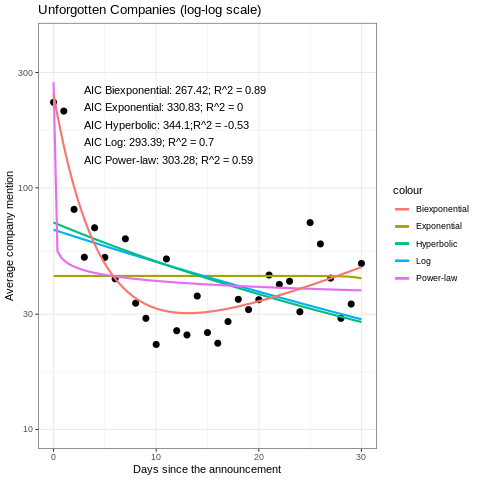

In [23]:
%%R

ggplot(Unforgotten, aes(x=number, y=avg)) + 
  geom_point(shape = 21, colour = "black", fill = "black", size = 2, stroke = 1) +
  #scale_x_continuous(trans = "log10", limits = c(1, 30)) +
  scale_y_continuous(trans = "log10", limits = c(10, 400)) +
  #coord_cartesian(ylim = c(0,500)) +
  geom_smooth(method="lm", aes(color="Exponential"), formula= (y ~ exp(x)), se=FALSE, linetype = 1) +
  geom_smooth(method = "glm", aes(color="Log"), formula = y~x, se=FALSE, method.args = list(family = gaussian(link = 'log')),linetype = 1) +
  geom_smooth(method = "nls", aes(color = "Hyperbolic"), formula = y ~ a/(1 + b * x), start = list(a = 1, b = 1), se = FALSE, linetype = 1) +
  geom_smooth(method = "nls", aes(color = "Power-law"), formula = y ~ a * (x+0.0000001)^(-b), se = FALSE, method.args = list(start = list(a = 1, b = 1))) +
  geom_smooth(method = "nls", aes(color = "Biexponential"), formula = y ~ a1*exp(-b1*x) + a2*exp(-b2*x), se = FALSE, method.args = list(start = c(a1 = 5, b1 = 2, a2 = 3, b2 = 0.5))) +
  ggtitle("Unforgotten Companies (log-log scale)") +
    ylab("Average company mention") + xlab("Days since the announcement")+
  annotate("text", x=3, y=255,  label= paste0("AIC Biexponential: ",round(AIC(biexp_fit_uf),2),("; R^2 = ") ,round(r_sqared(biexp_fit_uf),2)),hjust = 0)+
  annotate("text", x=3, y=215, label= paste0("AIC Exponential: ", round(gof(expmodel_uf)$AIC,2), "; R^2 = " ,round(r_sqared(expmodel_uf),2)),hjust = 0) +
  annotate("text", x=3, y=182, label= paste0("AIC Hyperbolic: ",round(AIC(hyper_fit_uf),2), ";R^2 = " ,round(r_sqared(hyper_fit_uf),2)),hjust = 0)+
  annotate("text", x=3, y=155, label= paste0("AIC Log: ",round(gof(logmodel_uf)$AIC,2),"; R^2 = " ,round(r_sqared(logmodel_uf),2)),hjust = 0)+
  annotate("text", x=3, y=130, label= paste0("AIC Power-law: ",round(AIC(power_fit_uf),2),"; R^2 = " ,round(r_sqared(power_fit_uf),2)),hjust = 0)+
  theme_bw()

### Model comparison: **Forgotten** companies

In [24]:
# Forgotten companies

%%R

forgotten <- tmp[ (tmp$company) %in% (df_2[df_2$After < df_2$Before,'Company']) & tmp$number >=0, ] # number:= number of days since bankruptcy announcement

forgotten <- sqldf("select avg(freq) as avg, number from forgotten group by number",method = "name__class")

forgotten_companies <- df_2[df_2$After < df_2$Before,'Company']
# number of companies
print( forgotten_companies )

 [1] "ArmstrongFloor"  "Carestream"      "CumulusMedia"    "DIESEL"         
 [5] "DeanAndDeLuca"   "EFCoalition"     "EnergyGulfport"  "IndianaTollRoad"
 [9] "KikoMilanoUSA"   "Momentive"       "MtGox"           "Perfumania"     
[13] "PyxusIntl"       "Rockport"        "SunEdison"       "Suntech_Connect"
[17] "TailorBrands"    "aeropostale"     "belk"            "cineworld"      
[21] "cobaltpowergrp"  "flyPAL"          "ftdflowers"      "guitarcenter"   
[25] "hhgregg"         "iHeartMedia"     "investvoyager"   "lootcrate"      
[29] "rue21"           "sugarfina"       "verso_group"    


In [27]:
# models
%%R

forgotten$x = forgotten$number
forgotten$y = forgotten$avg

# Exponential
expmodel_f <- lm(y~exp(x), data = forgotten)
print(summary(expmodel_f))

# Log
logmodel_f <- lm(y~log(x+0.01), data = forgotten)
print(summary(logmodel_f))

# Hyperbolic
hyper_fit_f <- nlsLM(y ~ a/(1 + b * x), data = forgotten, start = list(a = 1, b = 1))
print(summary(hyper_fit_f))

# Biexponential
biexp_fit_f <- nlsLM(y ~ a1*exp(-b1*x) + a2*exp(-b2*x), data = forgotten, start = c(a1 = 5, b1 = 2, a2 = 3, b2 = 0.5))
print(summary(biexp_fit_f))

# Fit a power law curve using nls
power_fit_f <- nls(y ~ a * (x+0.0001)^(-b), data = forgotten, start = list(a = 1, b = 1))
summary(power_fit_f)


Call:
lm(formula = y ~ exp(x), data = forgotten)

Residuals:
   Min     1Q Median     3Q    Max 
-31.96 -22.86  -7.89  13.81 151.58 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.542e+01  6.850e+00   9.551 1.85e-10 ***
exp(x)      -4.806e-12  3.319e-12  -1.448    0.158    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 36.78 on 29 degrees of freedom
Multiple R-squared:  0.06743,	Adjusted R-squared:  0.03527 
F-statistic: 2.097 on 1 and 29 DF,  p-value: 0.1583


Call:
lm(formula = y ~ log(x + 0.01), data = forgotten)

Residuals:
    Min      1Q  Median      3Q     Max 
-26.258  -8.873   0.340   7.399  33.002 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    113.342      5.157   21.98  < 2e-16 ***
log(x + 0.01)  -22.352      1.901  -11.76 1.49e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.86 on 29 degrees of fr

In [28]:
%%R
print(paste0("AIC exp: ", gof(expmodel_f)$AIC))
print(paste0("AIC log: ",gof(logmodel_f)$AIC))
print(paste0("AIC hypr: ",AIC(hyper_fit_f)))
print(paste0("AIC biex: ",AIC(biexp_fit_f)))
print(paste0("AIC power: ",AIC(power_fit_f)))

[1] "AIC exp: 315.418623805469"
[1] "AIC log: 263.274084155152"
[1] "AIC hypr: 349.355827761681"
[1] "AIC biex: 265.473980251324"
[1] "AIC power: 278.691842631233"


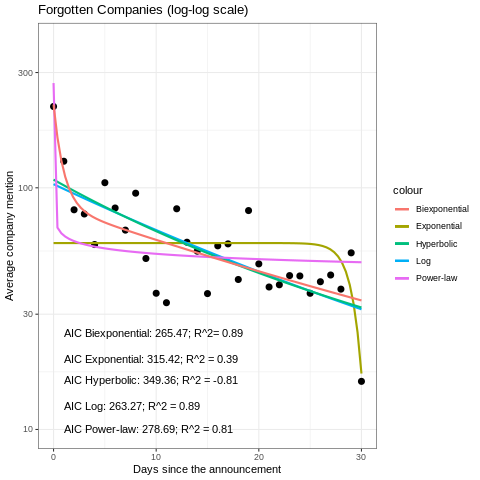

In [29]:
%%R

ggplot(forgotten, aes(x=number, y=avg)) + 
  geom_point(shape = 21, colour = "black", fill = "black", size = 2, stroke = 1) +
  #scale_x_continuous(trans = "log10", limits = c(1, 30)) +
  scale_y_continuous(trans = "log10", limits = c(10, 400)) +
  #coord_cartesian(ylim = c(0,500)) +
  geom_smooth(method="lm", aes(color="Exponential"), formula= (y ~ exp(x)), se=FALSE, linetype = 1) +
  geom_smooth(method = "glm", aes(color="Log"), formula = y~x, se=FALSE, method.args = list(family = gaussian(link = 'log')),linetype = 1) +
  geom_smooth(method = "nls", aes(color = "Hyperbolic"), formula = y ~ a/(1 + b * x), start = list(a = 1, b = 1), se = FALSE, linetype = 1) +
  geom_smooth(method = "nls", aes(color = "Power-law"), formula = y ~ a * (x+0.0000001)^(-b), se = FALSE, method.args = list(start = list(a = 1, b = 1))) +
  geom_smooth(method = "nls", aes(color = "Biexponential"), formula = y ~ a1*exp(-b1*x) + a2*exp(-b2*x), se = FALSE, method.args = list(start = c(a1 = 5, b1 = 2, a2 = 3, b2 = 0.5))) +
  ggtitle("Forgotten Companies (log-log scale)") +
    ylab("Average company mention") + xlab("Days since the announcement")+
  annotate("text", x=1, y=25,  label= paste0("AIC Biexponential: ",round(AIC(biexp_fit_f),2),"; ",expression(R^2), "= " ,round(r_sqared(biexp_fit_f),2)),hjust = 0)+
  annotate("text", x=1, y=19.5, label= paste0("AIC Exponential: ", round(gof(expmodel_f)$AIC,2), "; R^2 = " ,round(r_sqared(expmodel_f),2)),hjust = 0) +
  annotate("text", x=1, y=16, label= paste0("AIC Hyperbolic: ",round(AIC(hyper_fit_f),2), "; R^2 = " ,round(r_sqared(hyper_fit_f),2)),hjust = 0)+
  annotate("text", x=1, y=12.5, label= paste0("AIC Log: ",round(gof(logmodel_f)$AIC,2),"; R^2 = " ,round(r_sqared(logmodel_f),2)),hjust = 0)+
  annotate("text", x=1, y=10, label= paste0("AIC Power-law: ",round(AIC(power_fit_f),2),"; R^2 = " ,round(r_sqared(power_fit_f),2)),hjust = 0)+
  theme_bw()

### Inter tweet time

In [30]:
%%R
data <- read_csv(paste0(PTH1,"2012_2022_bankruptcy.csv.zip"), show_col_types = FALSE)


# split data into before and after the announcement
before <- data[grepl( 'before', data$data, fixed = TRUE),]
after <- data[grepl( 'after', data$data, fixed = TRUE),]

# delete messages originated by the companies
after <- after[!after$author_id %in% metadata$UserID,]
before <- before[!before$author_id %in% metadata$UserID,]



# keep only companies that we want to analyze
after<-after[after$company %in% tmp$company,]
before<-before[before$company %in% tmp$company,]


In [31]:
%%R
# before unforgotten
before_unforgot <- before[before$company %in% (Unforgotten_companies),]
my_datetime <- as.POSIXct(before_unforgot$created_at, format="%Y-%m-%d %H:%M:%S", tz="UTC")
my_datetime <- my_datetime[order(as.Date(my_datetime), decreasing = TRUE)]
my_datetime <- cbind(my_datetime[1:(length(my_datetime)-1)], my_datetime[2:(length(my_datetime))])

# inter Tweet time
inter_Tweet_time_before_unforgot <- data.frame(my_datetime[,1] - my_datetime[,2])
names(inter_Tweet_time_before_unforgot) <- "diff_before_unforgot"

In [32]:
%%R
# before forgotten
before_forgot <- before[before$company %in% (forgotten_companies),]
my_datetime <- as.POSIXct(before_forgot$created_at, format="%Y-%m-%d %H:%M:%S", tz="UTC")
my_datetime <- my_datetime[order(as.Date(my_datetime), decreasing = TRUE)]
my_datetime <- cbind(my_datetime[1:(length(my_datetime)-1)], my_datetime[2:(length(my_datetime))])

# inter Tweet time
inter_Tweet_time_before_forgot <- data.frame(my_datetime[,1] - my_datetime[,2])
names(inter_Tweet_time_before_forgot) <- "diff_before_forgot"

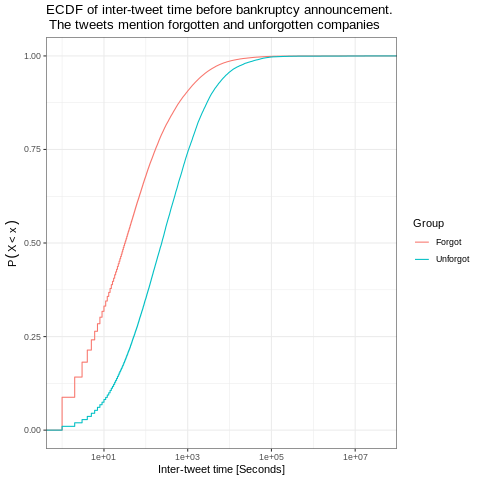

In [33]:
%%R
library(ggplot2)

# Create example data with two vectors of unequal lengths
set.seed(123)
x <- inter_Tweet_time_before_forgot$diff_before_forgot
y <- inter_Tweet_time_before_unforgot$diff_before_unforgot

# Merge the two vectors into a single data frame
df <- data.frame(Inter_Tweet_Time = c(x, y),
                 Group = factor(rep(c("Forgot", "Unforgot"), c(length(x), length(y)))))

# Create ECDF plot
ggplot(df, aes(Inter_Tweet_Time, color = Group)) +
  stat_ecdf() +
  scale_x_log10() +
  #scale_y_log10() +
  ggtitle("ECDF of inter-tweet time before bankruptcy announcement. \n The tweets mention forgotten and unforgotten companies") +
    ylab(expression(P(X<x))) + xlab("Inter-tweet time [Seconds]")+
  theme_bw()


To test H1 and reveal whether forgotten and unforgotten companies have different temporal inforamtion spreading patterns, we compare the distribution of the ECDFs by using the Kolmogorov-Smirnov (KS) D-statistic test. 
The D-statistic is defined as the maximum distance: D = max(|F1(x) − F2(x)|), where x represents the range of the random variable, and F1 and F2 represent the empirical cumulative distributions functions. 
The smaller the distance, the more similar the distribution curves and, hence, the more likely are the two samples to come from the same distribution.
In the KS-test, a p_value < 0.05 indicates that the samples are **not** drawn from the same distribution

In [34]:
# KS-test
%%R

ks.test(x, y)


	Asymptotic two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.36003, p-value < 2.2e-16
alternative hypothesis: two-sided



### Logistic regression


1. **avg_time_from_first** - Time difference from the posting of the FIRST tweet about the company.
  * Captures bursty user interactions [59, 60], which can explain contagion spread [61].

2. ***Pre-announcement mean***: Arithmetic mean of number of mentions in days $t \in [-30, 0]$, prior to bankruptcy announcement.


3. ***Num_of_tweets_before***   
  * Captures contagion spread similar to non-structural models (Section 2.2).


4. ***Followers***


5. ***Short-term boost***: Maximum mentions during days $t=0$ through $t=6$ following bankruptcy announcement, minus the pre-announcement mean.




%----------

3. Long-term boost: arithmetic mean of days 7 through 30 after bankruptcy announcement, minus the pre-announcement mean.

4. Halving time: number of days required to accumulate half of the total area between the post-announcement curve (including the day of the announcement) and the minimum post-announcement value.

#### data preperation

In [42]:
# 1) Average time difference betweeb the posting time of a tweet and the posting of the FIRST tweet about the company

%%R

before <- before %>% group_by(company) %>% mutate(min_value = min(created_at)) # find the time of the first post

before$time_from_first <- as.Date(before$created_at) - as.Date(before$min_value)


result <- sqldf("select company, avg(time_from_first) as avg_time_from_first from before group by company")

In [43]:
# 2) Pre-announcement mean
%%R

Pre_announcement_mean = sqldf("select avg(freq) as Pre_announcement_mean, company from tmp where `when`='before' group by company")

result <- merge(result, Pre_announcement_mean, by = 'company')

In [44]:
# 3) number of tweet before the announcement
%%R

number_of_tweets_before = sqldf("select company, count(1) as number_of_tweets_before from before group by company")

result <- merge(result, number_of_tweets_before, by = 'company')

In [45]:
# 4) Followers

%%R
df <- metadata[,c('Company Name','Twitter Username','Twitter Followers', 'Twitter Following','Twitter Lists','Avg_Google_Trends')]

result <- merge(result, df,  by.x = 'company', by.y = 'Twitter Username')

In [46]:
# 5) Short-term boost
%%R

Short_term_boost <- sqldf("select max(freq) as shrt_boost, company from tmp where `when`='after'and number between 0 and 11 group by company")


In [47]:
%%R

result <- merge(result, Short_term_boost, by = 'company')

result$shrt_boost <- result$shrt_boost - result$Pre_announcement_mean

In [517]:
# confidence intervals

%%R

library(DescTools)
MedianCI(Short_term_boost$shrt_boost,
         conf.level = 0.95,
         na.rm = FALSE,
         method = "exact",
         R = 10000)

median lwr.ci upr.ci 
    41     17    104 
attr(,"conf.level")
[1] 0.9578346


In [48]:
# set target variable
%%R
result$y <- 0
result[result$company %in% forgotten_companies, 'y'] <- 1

result$company_name <- NULL

#### Regression

In [49]:
%%R
result$y <- as.factor(result$y)

In [70]:
%%R

# Specify the proportion of data to be used for train
train_proportion <- 0.8

# Split the data into training and test sets
set.seed(123) # Set a random seed for reproducibility
train_indices <- createDataPartition(y = result$y, p = train_proportion, list = FALSE)
train_data <- result[train_indices, ]
test_data <- result[-train_indices, ]

In [ ]:
# logistic regression

%%R

# define training control cross validation
train_control <- trainControl(method = "cv", number = 10)

# train the model on training set
model <- train(y ~ avg_time_from_first + Pre_announcement_mean + number_of_tweets_before + `Twitter Followers` + `Twitter Following` + shrt_boost,
               family = binomial(),
               trControl = train_control,
               method = "glmStepAIC",
               direction ="backward", # forward
               data = train_data,
               trace = 2)

In [98]:
%%R
# print cv scores
print(summary(model))


# check varibale importance
varImp(model$finalModel)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5945  -0.4602   0.0000   0.1194   2.4414  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)  
(Intercept)           -1.05879    0.62576  -1.692   0.0906 .
Pre_announcement_mean  0.63883    0.29166   2.190   0.0285 *
shrt_boost            -0.14894    0.06626  -2.248   0.0246 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 85.635  on 63  degrees of freedom
Residual deviance: 39.799  on 61  degrees of freedom
AIC: 45.799

Number of Fisher Scoring iterations: 12

                       Overall
Pre_announcement_mean 2.190339
shrt_boost            2.247676


In [100]:
# Evaluation of the best model of the cross validation

%%R

threshold=0.3
predicted_values<-as.factor(ifelse(predict(model$finalModel,type="response")>threshold,1,0))
actual_values<-as.factor(model$finalModel$y)
confusionMatrix(predicted_values, actual_values, mode = "everything", positive="0")

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 27  1
         1 12 24
                                          
               Accuracy : 0.7969          
                 95% CI : (0.6777, 0.8872)
    No Information Rate : 0.6094          
    P-Value [Acc > NIR] : 0.001100        
                                          
                  Kappa : 0.6046          
                                          
 Mcnemar's Test P-Value : 0.005546        
                                          
            Sensitivity : 0.6923          
            Specificity : 0.9600          
         Pos Pred Value : 0.9643          
         Neg Pred Value : 0.6667          
              Precision : 0.9643          
                 Recall : 0.6923          
                     F1 : 0.8060          
             Prevalence : 0.6094          
         Detection Rate : 0.4219          
   Detection Prevalence : 0.4375          
      Balanced Accuracy : 0.8262    

In [102]:
# Make predictions on the test set
%%R

test_predictions <- predict(model$finalModel, newdata = test_data,type = "response")

# Set a threshold value (e.g., 0.5) for binary classification
threshold <- 0.5

# Convert predicted probabilities to binary values based on the threshold
test_predictions <- as.factor(ifelse(test_predictions > threshold, 1, 0))

test_data$y <- as.factor(test_data$y)

# Compute the confusion matrix
confusionMatrix(test_predictions, test_data$y, mode = "everything", positive="1")


Confusion Matrix and Statistics

          Reference
Prediction 0 1
         0 7 0
         1 2 6
                                          
               Accuracy : 0.8667          
                 95% CI : (0.5954, 0.9834)
    No Information Rate : 0.6             
    P-Value [Acc > NIR] : 0.02711         
                                          
                  Kappa : 0.7368          
                                          
 Mcnemar's Test P-Value : 0.47950         
                                          
            Sensitivity : 1.0000          
            Specificity : 0.7778          
         Pos Pred Value : 0.7500          
         Neg Pred Value : 1.0000          
              Precision : 0.7500          
                 Recall : 1.0000          
                     F1 : 0.8571          
             Prevalence : 0.4000          
         Detection Rate : 0.4000          
   Detection Prevalence : 0.5333          
      Balanced Accuracy : 0.8889          

# Other measures

In [ ]:
# 3) Long-term boost
%%R

Long_term_boost = sqldf("select avg(freq) as lng_boost, company from tmp where `when`='after' and number between 7 and 40 group by company")
Long_term_boost$shrt_boost <- Long_term_boost$lng_boost - Pre_announcement_mean$avgfreq

print(Long_term_boost)

library(DescTools)
MedianCI(Long_term_boost$shrt_boost,
         conf.level = 0.95,
         na.rm = FALSE,
         method = "exact",
         R = 10000)

In [ ]:
%%R
# Halving time - manual run: play with `win` variable to detect when the area under the graph (`x`) is 0.5
# calculate AUC

comp = 'TrueReligion'
win = 3
x = AUC(x=tmp[tmp$when =='after'& tmp$company==comp,]$number[1:win], y=tmp[tmp$when =='after'& tmp$company==comp,]$freq[1:win]) / 
                                                                    AUC(x=tmp[tmp$when =='after'& tmp$company==comp,]$number, y=tmp[tmp$when =='after'& tmp$company==comp,]$freq)

print(x)

[1] 0.5923533


In [ ]:
%%R



halving = rbind(
    c('beautybrands',	7),
    c('CharlotteRusse',	5),
    #c('CharmingCharlie',	5),
    c('claires',	21),
    c('DIESEL',	17),
    c('Forever21',	7),
    c('ftdflowers',	14),
    c('hhgregg',	9),
    c('MattressFirm',	14),
    c('NineWest',	5),
    c('Perfumania',	12),
    c('Rockport',	11),
    c('rue21',	15),
    c('Sears',	4),
    c('sugarfina',	13),
    c('TrueReligion',	3)
)


halving = data.frame(halving)
names(halving) = c("company","halving")
halving

          company halving
1    beautybrands       7
2  CharlotteRusse       5
3         claires      21
4          DIESEL      17
5       Forever21       7
6      ftdflowers      14
7         hhgregg       9
8    MattressFirm      14
9        NineWest       5
10     Perfumania      12
11       Rockport      11
12          rue21      15
13          Sears       4
14      sugarfina      13
15   TrueReligion       3


#### plot daily tweet count per company

In [ ]:
%%R
# create a list of ggplots

figures <- list()
i = 1
for(comp in unique(tmp$company)){
  figures[[i]] <- ggplot(data=tmp[tmp$company==comp,], aes(x=number, y=freq)) +
                      geom_line()+
                      theme_bw() +
                      labs(x="Days from bankruptcy announcment", y = "Number of tweets")+
                      ggtitle(paste0("@",comp)) +
                      theme(plot.title = element_text(hjust = 0.5)) +
                      geom_point()
  i = i +1
}

In [ ]:
# plot the figures

p<-ggarrange(figures[[1]],figures[[2]],figures[[3]],figures[[4]],figures[[5]],figures[[6]],figures[[7]],
          figures[[8]],figures[[9]],figures[[10]],figures[[11]],figures[[12]],figures[[13]],figures[[14]],
          figures[[15]], figures[[16]],
          ncol = 4, nrow = 5)
options(repr.plot.width = 12, repr.plot.height = 12) # set canvas size
print(p)
ggexport(p, filename = "figures.pdf", width = 12, height = 12) # write figure to pdf

#### plot average number of tweets before vs. after the announcement for all companies

In [ ]:
%%R
# average number of tweets before and after the announcement
fig2 <- sqldf("select number, avg(freq) as n_d from tmp group by number",method = "name__class")
write.csv(fig2, file="fig2.csv")

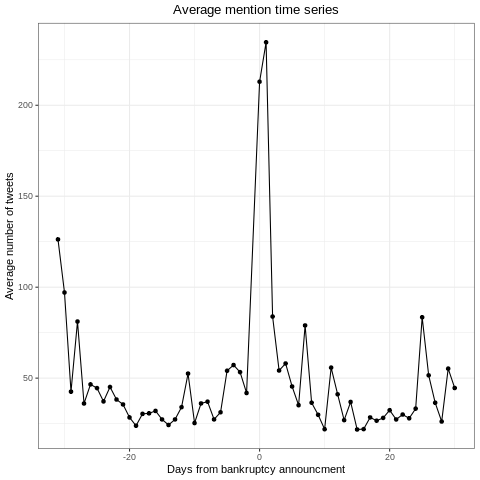

In [ ]:
%%R
p2<-ggplot(data=fig2, aes(x=number, y=n_d)) +
                      geom_line()+
                      #scale_y_continuous(trans='log10')+
                      theme_bw() +
                      labs(x="Days from bankruptcy announcment", y = "Average number of tweets")+
                      ggtitle("Average mention time series") +
                      theme(plot.title = element_text(hjust = 0.5)) +
                      #geom_hline(yintercept=mean(fig2[fig2$number!=0,]$n_d), linetype="dashed", color = "red") +
                      geom_point()

print(p2)

ggexport(p2, filename = "figures3.pdf", width = 6, height = 6) # write figure to pdf

## clustering

In [ ]:
%%R
df_four_measures = data.frame(
                              'Pre_announcement_mean' = Pre_announcement_mean$avgfreq, 
                              'Short_term_boost' = Short_term_boost$shrt_boost,
                              'Long_term_boost' = Long_term_boost$lng_boost,
                              'Halving' = as.numeric(halving$halving)
                              )

df_four_measures

   Pre_announcement_mean Short_term_boost Long_term_boost Halving
1               7.633333      79.36666667        6.523810       7
2               1.941176       0.05882353        1.375000       5
3              23.888889      15.11111111       22.458333       5
4             172.766667     847.23333333      106.739130      21
5              18.344828     201.65517241       28.291667      17
6               6.633333      57.36666667        5.772727       7
7              16.782609      -0.78260870       19.833333      14
8               4.913043      12.08695652        3.500000       9
9             130.689655    1632.31034483       95.625000      14
10              9.827586     384.17241379       12.208333       5
11              1.954545      14.04545455        3.181818      12
12             71.740741     189.25925926      151.333333      11
13             19.857143       3.14285714        2.789474      15
14             46.666667      34.33333333       11.375000       4
15        

In [ ]:
%%R
mat = as.matrix(df_four_measures)

In [ ]:
%%R

res<-NbClust(mat, distance = "euclidean", min.nc=2, max.nc=10, method = "kmeans", index = "all")

# plot
library("factoextra")
fviz_nbclust(res)

In [ ]:
%%R
# do k-means
kmeans_fancy <- kmeans(scale(mat), 2, nstart = 100)


df_four_measures$company <- halving$company
df_four_measures$kmeans <- kmeans_fancy$cluster
df_four_measures

   Pre_announcement_mean Short_term_boost Long_term_boost Halving
1               7.633333      79.36666667        6.523810       7
2               1.941176       0.05882353        1.375000       5
3              23.888889      15.11111111       22.458333       5
4             172.766667     847.23333333      106.739130      21
5              18.344828     201.65517241       28.291667      17
6               6.633333      57.36666667        5.772727       7
7              16.782609      -0.78260870       19.833333      14
8               4.913043      12.08695652        3.500000       9
9             130.689655    1632.31034483       95.625000      14
10              9.827586     384.17241379       12.208333       5
11              1.954545      14.04545455        3.181818      12
12             71.740741     189.25925926      151.333333      11
13             19.857143       3.14285714        2.789474      15
14             46.666667      34.33333333       11.375000       4
15        

R[write to console]: file saved to figures3c.pdf



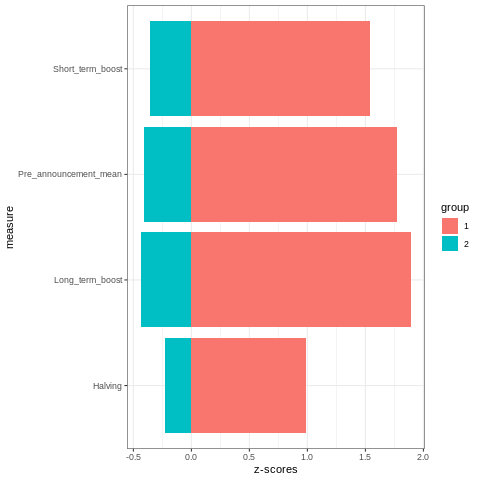

In [ ]:
%%R
df_centroids = data.frame(kmeans_fancy$centers)
df_centroids <- t(df_centroids)
df_centroids <- data.frame(df_centroids)
df_centroids$measure<-row.names(df_centroids)
row.names(df_centroids)<-NULL

one <- data.frame(df_centroids[,c(1,3)])
one$group<-"1"
names(one)[1]<-"z-scores"
two <- data.frame(df_centroids[,c(2,3)])
two$group<-'2'
names(two)[1]<-"z-scores"

df_centroids<-rbind(one, two)

# do k-means
g<- ggplot(df_centroids, aes(measure,`z-scores`,fill=group)) +
  geom_col()+
  theme_bw() +
  coord_flip()

print(g)
ggexport(g, filename = "figures3c.pdf", width = 4, height = 4) # write figure to pdf

In [ ]:
%%R
df_four_measures

## figure 3. average mention time series by group

In [ ]:
%%R
tmp <- read_csv("/content/drive/MyDrive/Colab Notebooks/BIU_HEB/data/data_rebuttle.csv", show_col_types = FALSE)

# remove TailorBrands
tmp <- tmp[!tmp$company %in% c('KikoMilanoUSA', ''),]

head(tmp[tmp$when == 'after',])

New names:
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
# A tibble: 6 × 9
  company      date        freq when  number ...6  ...7  ...8  ...9 
  <chr>        <chr>      <dbl> <chr>  <dbl> <lgl> <lgl> <lgl> <lgl>
1 beautybrands 07/01/2019    16 after      1 NA    NA    NA    NA   
2 beautybrands 08/01/2019     3 after      2 NA    NA    NA    NA   
3 beautybrands 09/01/2019     7 after      3 NA    NA    NA    NA   
4 beautybrands 12/01/2019     5 after      6 NA    NA    NA    NA   
5 beautybrands 13/01/2019     6 after      7 NA    NA    NA    NA   
6 beautybrands 16/01/2019     3 after     10 NA    NA    NA    NA   


In [ ]:
%%R
group1<-tmp[tmp$company %in% df_four_measures[df_four_measures$kmeans==1,]$company,]
group1$group<-'C1'
group2<-tmp[tmp$company %in% df_four_measures[df_four_measures$kmeans==2,]$company,]
group2$group<-'C2'
group_data <- rbind(group1,group2)
fig3b <- sqldf("select number, `group`, avg(freq) as n_d from group_data group by number, `group`")
fig3b$group <- as.factor(fig3b$group)
head(fig3b)

  number group       n_d
1    -31    C2 126.28571
2    -30    C1  14.50000
3    -30    C2 103.36364
4    -29    C1  10.00000
5    -29    C2  44.72727
6    -28    C1  17.66667


R[write to console]: file saved to figures3b.pdf



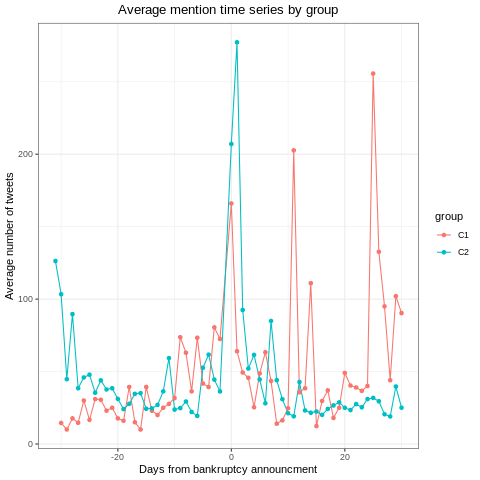

In [ ]:
%%R
p2<-ggplot(data=fig3b, aes(x=number, y=n_d, group=group, colour=group)) +
                      geom_line()+
                      theme_bw() +
                      labs(x="Days from bankruptcy announcment", y = "Average number of tweets")+
                      ggtitle("Average mention time series by group") +
                      theme(plot.title = element_text(hjust = 0.5)) +
                      geom_point()

print(p2)

ggexport(p2, filename = "figures3b.pdf", width = 6, height = 6) # write figure to pdf

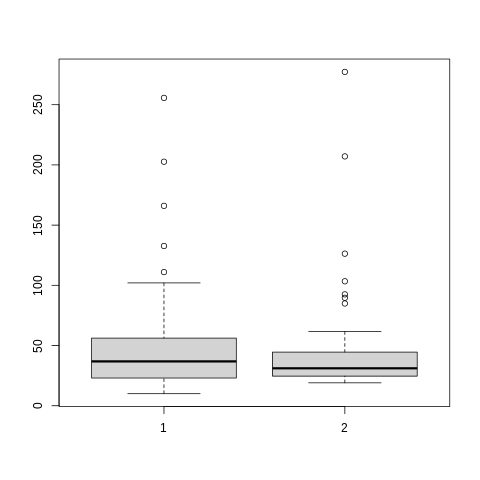

In [ ]:
%%R
boxplot(fig3b[fig3b$group=='C1',]$n_d, fig3b[fig3b$group=='C2',]$n_d)

In [ ]:
%%R
# mean of 3 out of the 4 parameters in each cluster
# mean(df_four_measures$Short_term_boost

#mean(df_four_measures[df_four_measures$kmeans=='1',]$Short_term_boost)
mean(df_four_measures[df_four_measures$kmeans=='2',]$Short_term_boost)

# Short_term_boost      C1: 617.7155           C2: 107.0955            ALL  298.578
# Long_term_boost       C1: 70.03487           C2 15.3411              ALL  35.85126
# Pre_announcement_mean C1: 51.11              C2 16.80455             ALL  29.67202

[1] 62.94734


## regression

1. Pre-announcement mean mention frequency.
2. Company age (year) at the day of bankruptcy announcement.
3. Bankruptcy strategy (factor with 5 levels: restructuring, reorganization, purchased, sold, closed all stores).
4. Market cup category (factor with 6 levels: specifying the main business of the company: sports, clothes, etc.
5. Market capitalization.
6. Gender of owners (factor with 3 levels: female, male, mixed).




In [ ]:
%%R
Pre_announcement_mean$avgfreq<-scale(Pre_announcement_mean$avgfreq)
Pre_announcement_mean

      avgfreq         company
1  -0.6115239  CharlotteRusse
2  -0.7271324 CharmingCharlie
3  -0.2813710          DIESEL
4   2.7423597       Forever21
5  -0.3939717    MattressFirm
6  -0.6318340        NineWest
7  -0.4257007      Perfumania
8  -0.6667734        Rockport
9   1.8877691           Sears
10 -0.5669582    TrueReligion
11 -0.7268609    beautybrands
12  0.6905075         claires
13 -0.3632564      ftdflowers
14  0.1812492         hhgregg
15  0.3049777           rue21
16 -0.4114805       sugarfina


In [ ]:
# average sentiment analysis of each company
# load before and after datasets
%%R

before <- read_csv(paste0(PTH1,"/before.csv"),col_types = cols(...1 = col_skip(), id = col_character(),
                                                                       in_reply_to_user_id = col_character(),
                                                                       author_id = col_character(), 
                                                                       conversation_id = col_character()))


before<-before[!before$company %in% c('DeanAndDeLuca', 'TailorBrands'),]

New names:
• `` -> `...1`


In [ ]:
%%R
tweets_R = before$text

In [ ]:
%R -o tweets_R tweets_R

"""There we...",'RT @Nint...,'RT @Nint...,...,'RT @hhgr...,'RT @hhgr...,"""@hhgregg..."


In [ ]:
import re
result = [re.sub(r'http\S+', '', x) for x in tweets_R]

In [ ]:
# https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis
from textblob import TextBlob

sentiment = []
subjectivity = []

for text in result:
  x = TextBlob(text)
  sentiment.append( x.sentiment[0] )
  subjectivity.append( x.sentiment[1] ) # The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [ ]:
# send back sentiment to R
%R -i sentiment sentiment
%R -i subjectivity subjectivity

## T-tests

In [ ]:
%%R
# reputation ratio
cl1=c(36.01754386,
56.8627451,
132.7731092,
146.4516129,
162.406015,
67700)


cl2=c(49.26624738,
85.17520216,
111.9669421,
113.8297872,
117.0572207,
144.9460647,
169.4719472,
203.6018957,
311.2852665,
74100)


wilcox.test(cl1,cl2)


	Wilcoxon rank sum exact test

data:  cl1 and cl2
W = 27, p-value = 0.7925
alternative hypothesis: true location shift is not equal to 0



In [ ]:
%%R
# difference in the number of Followers

cluster1=c(67700,
43200,
22700,
14500,
110600,
6159)


cluster2=c(192600,
102700,
74100,
23500,
99300,
214800,
429600,
338700,
63200,
362800)


t.test(cluster1,cluster2)


	Welch Two Sample t-test

data:  cluster1 and cluster2
t = -3.0489, df = 11.109, p-value = 0.01095
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -251248.32  -40725.35
sample estimates:
mean of x mean of y 
 44143.17 190130.00 



In [ ]:
%%R
# difference in the number of lists

clst1=c(171,
255,
833,
155,
266,
1)


clst2=c(477,
742,
3025,
1692,
1835,
2503,
606,
2110,
319,
1)


t.test(clst1,clst2)


	Welch Two Sample t-test

data:  clst1 and clst2
t = -3.0244, df = 11.129, p-value = 0.01143
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1814.4995  -287.1672
sample estimates:
mean of x mean of y 
 280.1667 1331.0000 



In [ ]:
%%R
# list into vector
sentiment = unlist(sentiment)
subjectivity = unlist(subjectivity)

In [ ]:
%%R
before$sentiment <- sentiment
before$subjectivity <- subjectivity

mean_sent_by_comp = sqldf("select avg(sentiment), company from before group by company")

mean_subj_by_comp = sqldf("select avg(subjectivity), company from before group by company")


mean_sent_by_comp<-mean_sent_by_comp[!mean_sent_by_comp$company %in% c('KikoMilanoUSA', ''),]
mean_subj_by_comp<-mean_subj_by_comp[!mean_subj_by_comp$company %in% c('KikoMilanoUSA', ''),]

In [ ]:
%%R
# number of tweets before
num_of_tweets_before = sqldf("select company, count(1) as n_tweets from before group by company")
num_of_tweets_before = num_of_tweets_before[num_of_tweets_before$company != "KikoMilanoUSA",]
num_of_tweets_before

           company n_tweets
1   CharlotteRusse      229
2  CharmingCharlie       33
3           DIESEL      645
4        Forever21     5183
6     MattressFirm      537
7         NineWest      199
8       Perfumania      386
9         Rockport      120
10           Sears     3797
11    TrueReligion      286
12    beautybrands       43
13         claires     1938
14      ftdflowers      557
15         hhgregg     1260
16           rue21     1531
17       sugarfina      507


In [ ]:
%%R
unique(before$company)

 [1] "sugarfina"       "Forever21"       "CharmingCharlie" "ftdflowers"     
 [5] "DIESEL"          "CharlotteRusse"  "beautybrands"    "Sears"          
 [9] "MattressFirm"    "Rockport"        "NineWest"        "claires"        
[13] "KikoMilanoUSA"   "Perfumania"      "TrueReligion"    "rue21"          
[17] "hhgregg"        


In [ ]:
%%R
# calculate mean inter-tweet time
inter_tweet_time = data.frame()
for(company in unique(before$company)){
    v = as.POSIXct( before[before$company==company,]$created_at , format = "%a %b %d %H:%M:%S %z %Y", tz="GMT")
    v = v[order(v , decreasing = TRUE )]
    d = diff(v)
    inter_tweet_time = rbind(inter_tweet_time, c(company, mean(d)))
}

names(inter_tweet_time) = c('company','avg_inter_time')
#inter_tweet_time = inter_tweet_time[order(num_of_tweets_before$company),]
inter_tweet_time = sqldf("select company, avg_inter_time/60 as avg_inter_time from inter_tweet_time group by company") # we do this to keep the order of companies
inter_tweet_time <- inter_tweet_time[inter_tweet_time$company != 'KikoMilanoUSA',]
inter_tweet_time

           company    avg_inter_time
1   CharlotteRusse -183.459210526315
2  CharmingCharlie -20.2715711805555
3           DIESEL -60.2850672877847
4        Forever21 -8.32957673999743
6     MattressFirm -77.8626865671642
7         NineWest -214.747643097643
8       Perfumania -106.192337662338
9         Rockport -317.968207282913
10           Sears -10.9990735862311
11    TrueReligion -142.552631578947
12    beautybrands -16.5759457671958
13         claires  -20.065969712614
14      ftdflowers -74.8082434052758
15         hhgregg -30.8718030182685
16           rue21 -27.2831045751633
17       sugarfina -84.9220355731225


In [ ]:
%%R

Company_type = c( 'Beauty',
                  'Clothing',
                  'Clothing',
                  'Department Store',
                  'Clothing',
                  'Clothing',
                  'Other',
                  'Department Store',
                  #'Beauty',
                  'Mattresses',
                  'Clothing',
                  'Beauty',
                  'Clothing',
                  'Other',
                  'Department Store',
                  'Other',
                  'Clothing'
                  )
                  
Followers = c(8403,
              72100,
              28500,
              65400,
              179000,
              1900000,
              12800,
              31800,
              #4367,
              47200,
              45400,
              19000,
              6294,
              32400,
              198100,
              22300,
              44600)


Following = c(
                707,
                9438,
                148,
                225,
                737,
                351,
                21,
                900,
                #47,
                554,
                387,
                159,
                940,
                1091,
                9293,
                172,
                193
                )

# mean web searched worldwide 1 month before the announcedment on Google Trends
Google_trends = c(
                  69.84,
                  74.9,
                  59.45,
                  35.86,
                  84.86,
                  54.93,
                  25.31,
                  50.06,
                  #
                  30.77,
                  64.93,
                  62.46,
                  87.38,
                  65.19,
                  28,
                  32.75,
                  11.51
                  )

public = c( 'Private',
            'Private',
            'Private',
            'Private',
            'Private',
            'Private',
            'Public',
            'Public',
            #'Private',
            'Private',
            'Private',
            'Public',
            'Private', 
            'Private',
            'Public',
            'Private', 
            'Private')

In [ ]:
%%R

df = data.frame(
                  'company' = Pre_announcement_mean$company,
                  'Pre_announcement_mean' = Pre_announcement_mean$avgfreq, 
                  'Company_type' = as.factor(Company_type), 
                  'Short_term_boost' = Short_term_boost$shrt_boost,
                  'Long_term_boost' = Long_term_boost$shrt_boost,
                  'avg_inter_time' = inter_tweet_time$avg_inter_time,
                  'num_of_tweets_before' = num_of_tweets_before$n_tweets,
                  'Followers' = Followers,
                  'Following' = Following,
                  'Google_trends' = Google_trends,
                  'public' = as.factor(public)
                )

In [ ]:
%%R
length(num_of_tweets_before$n_tweets)

[1] 16


In [ ]:
# *** predicct short-term boost ***
%%R

df$Company_type <- relevel(df$Company_type, ref = 'Clothing') # Clothing
df$public <- relevel(df$public, ref = 'Private')


library(MASS)
# Fit the full model 
full.model <-lm(df$Short_term_boost ~ 
                                df$Pre_announcement_mean +
                                #df$mean_sent_by_comp +
                                #df$avg_inter_time +
                                df$Company_type +
                                df$Google_trends +
                                df$num_of_tweets_before +
                                df$public
                                #+df$Followers+
                                #df$Following +
                                #df$mean_subj_by_comp
                )

# Stepwise regression model
step.model <- stepAIC(full.model, direction = "both", 
                      trace = FALSE)
summary(step.model)


Call:
lm(formula = df$Short_term_boost ~ df$Pre_announcement_mean + 
    df$Company_type + df$Google_trends + df$num_of_tweets_before + 
    df$public)

Residuals:
   Min     1Q Median     3Q    Max 
-85.76 -52.15 -17.59  12.49 252.08 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     -1797.9842   794.0483  -2.264  0.05796 .  
df$Pre_announcement_mean        -2244.8735  1005.6039  -2.232  0.06076 .  
df$Company_typeBeauty            -139.4301   127.4465  -1.094  0.31015    
df$Company_typeDepartment Store  -151.4306   165.2964  -0.916  0.39008    
df$Company_typeMattresses        1107.1338   181.4265   6.102  0.00049 ***
df$Company_typeOther             -122.1629    98.9935  -1.234  0.25700    
df$Google_trends                    2.6056     1.8317   1.422  0.19789    
df$num_of_tweets_before             1.7068     0.7012   2.434  0.04515 *  
df$publicPublic                   154.7660   144.9097   1.068  0.32095   

In [ ]:
# *** predict long-term boost ***
%%R
model2<-lm(log(Long_term_boost) ~     Pre_announcement_mean +
                                      #as.numeric(avg_inter_time) +
                                      Followers + 
                                      Short_term_boost,
                                    data = df
                                      )
                                      

summary(model2)


Call:
lm(formula = log(Long_term_boost) ~ Pre_announcement_mean + Followers + 
    Short_term_boost, data = df)

Residuals:
         5          7         10         11         12 
-0.0001057  0.0251870  0.0037865 -0.0231138 -0.0057540 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)   
(Intercept)            2.280e+00  2.640e-02  86.370  0.00737 **
Pre_announcement_mean  2.999e+00  3.269e-02  91.756  0.00694 **
Followers              6.765e-06  2.633e-07  25.691  0.02477 * 
Short_term_boost      -6.078e-05  1.184e-04  -0.514  0.69799   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03487 on 1 degrees of freedom
  (11 observations deleted due to missingness)
Multiple R-squared:  0.9999,	Adjusted R-squared:  0.9995 
F-statistic:  2951 on 3 and 1 DF,  p-value: 0.01353



In [ ]:
%%R
(df$Long_term_boost)

 [1]  -1.1095238  -0.5661765  -1.4305556 -66.0275362   9.9468391  -0.8606061
 [7]   3.0507246  -1.4130435 -35.0646552   2.3807471   1.2272727  79.5925926
[13] -17.0676692 -35.2916667 -10.2169540 -13.6327586


In [ ]:
%%R
names(df)

 [1] "company"               "Pre_announcement_mean" "Company_type"         
 [4] "Short_term_boost"      "Long_term_boost"       "avg_inter_time"       
 [7] "num_of_tweets_before"  "Followers"             "Following"            
[10] "Google_trends"         "public"               
